In [2]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout, Flatten
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, RobustScaler,OrdinalEncoder, LabelEncoder, OneHotEncoder, KBinsDiscretizer, PolynomialFeatures
import seaborn as sns
from datetime import datetime
from sklearn.compose import make_column_transformer, ColumnTransformer

from keras.optimizers import SGD

from pandas import DataFrame
from pandas import concat
from numpy import concatenate

from sklearn.metrics import mean_squared_error

import matplotlib.dates as mdates

from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

import logging
logging.getLogger('tensorflow').disabled = True

from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

import holidays

%config IPCompleter.use_jedi = False
import os
import pandas as pd
import numpy as np
import math
from collections import Counter
from datetime import datetime
import holidays
import graphviz
import warnings

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import ipywidgets as widgets
import plotly.io as pio
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import shap

import xgboost as xgb
import keras
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, precision_score, recall_score, accuracy_score, classification_report, brier_score_loss,f1_score, classification_report, confusion_matrix, RocCurveDisplay, auc, roc_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, RobustScaler,OrdinalEncoder, LabelEncoder, OneHotEncoder, KBinsDiscretizer, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV,RandomizedSearchCV, StratifiedKFold, validation_curve, learning_curve, cross_val_score, RepeatedStratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.inspection import permutation_importance 
from sklearn.feature_extraction import DictVectorizer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.calibration import calibration_curve, CalibratedClassifierCV


%matplotlib inline
sns.set_style('dark')
# shap.initjs()


# Data-preprocessing

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [5]:
def werktijd(uur):
    if 9 <= uur < 17:
        return True
    else:
        return False

In [7]:
df = pd.read_csv('model_data.csv',index_col=0, parse_dates=True)
print(df.columns)
display(df.head(5))

Index(['dtg_melding', 'statnaam', 'naam_locatie_1', 'long', 'lat'], dtype='object')


,dtg_melding,statnaam,naam_locatie_1,long,lat
tijd,,,,,
2018-05-15 00:34:09.999840,2018-05-15 00:34:09.999840,Gorinchem,Banneweg,4.957682,51.838642
2018-05-15 00:35:16.999584,2018-05-15 00:35:16.999584,Molenlanden,Poldermolen,4.820888,51.876255
2018-05-15 00:39:15.999264,2018-05-15 00:39:15.999264,Hoeksche Waard,Dorpzigt,4.368100,51.750697
2018-05-15 00:41:44.999520,2018-05-15 00:41:44.999520,Dordrecht,Minnaertweg,4.685803,51.782934
2018-05-15 00:45:27.999648,2018-05-15 00:45:27.999648,Gorinchem,Banneweg,4.956150,51.839491


In [8]:
df_mod = df.copy()
df_mod= df.resample('30T').agg({'dtg_melding': 'count'})

df_mod['dtg_melding'] = df_mod['dtg_melding'].astype(int)

print(df_mod.shape)
# print(df_mod.isnull().sum())
display(df_mod.head(5))

(34463, 1)


,dtg_melding
tijd,
2018-05-15 00:30:00,8
2018-05-15 01:00:00,0
2018-05-15 01:30:00,1
2018-05-15 02:00:00,1
2018-05-15 02:30:00,0


In [9]:
# print(type(df_mod.index))
# df_mod['jaar'] = pd.DatetimeIndex(df_mod.index).year
df_mod['maand'] = pd.DatetimeIndex(df_mod.index).month
df_mod['kwartaal'] = pd.DatetimeIndex(df_mod.index).quarter
df_mod['weekvanjaar'] = pd.DatetimeIndex(df_mod.index).isocalendar().week
df_mod['weekdag'] = pd.DatetimeIndex(df_mod.index).weekday
df_mod['dagvanjaar'] = pd.DatetimeIndex(df_mod.index).dayofyear
df_mod['dag'] = pd.DatetimeIndex(df_mod.index).day
df_mod['dagdeel'] = pd.DatetimeIndex(df_mod.index).hour
df_mod['uur'] = pd.DatetimeIndex(df_mod.index).hour
df_mod['werktijd'] = pd.DatetimeIndex(df_mod.index).hour
df_mod['minuten'] = pd.DatetimeIndex(df_mod.index).minute
df_mod['werkdag'] = pd.DatetimeIndex(df_mod.index).weekday < 5
# df_mod['begin_van_maand'] = pd.DatetimeIndex(df_mod.index).is_month_start
# df_mod['eind_van_maand'] = pd.DatetimeIndex(df_mod.index).is_month_end
df_mod['lopend_gemiddelde_2u'] = df_mod['dtg_melding'].rolling(window=4, min_periods=1).mean()
df_mod['lopend_gemiddelde_6u'] = df_mod['dtg_melding'].rolling(window=12, min_periods=1).mean()
df_mod['lopend_gemiddelde_dag'] = df_mod['dtg_melding'].rolling(window=48, min_periods=1).mean()
df_mod['uitbereidend_gemiddelde'] = df_mod['dtg_melding'].expanding(min_periods=1).mean()
df_mod['weekend'] = df_mod['weekdag'] > 4
# df_mod['weekGemiddelde'] = df_mod['weekvanjaar'].mean()

# Binning = Categorizing data based on threshold values
bins = [-np.inf, 6, 12, 18, 24]
dagdelen = ['nacht','ochtend', 'middag', 'avond']
df_mod['dagdeel'] = pd.cut(df_mod['dagdeel'], bins, labels=dagdelen)

winter2018 = [datetime.strptime("2018-01-01 00:00:00", '%Y-%m-%d %H:%M:%S'), datetime.strptime("2018-03-20 23:59:59", '%Y-%m-%d %H:%M:%S')]
lente2018 = [datetime.strptime("2018-03-21 00:00:00", '%Y-%m-%d %H:%M:%S'), datetime.strptime("2018-06-20 23:59:59", '%Y-%m-%d %H:%M:%S')]
zomer2018 = [datetime.strptime("2018-06-21 00:00:00", '%Y-%m-%d %H:%M:%S'), datetime.strptime("2018-09-22 23:59:59", '%Y-%m-%d %H:%M:%S')]
herfst2018 = [datetime.strptime("2018-09-23 00:00:00", '%Y-%m-%d %H:%M:%S'), datetime.strptime("2018-12-20 23:59:59", '%Y-%m-%d %H:%M:%S')]
winter201819 = [datetime.strptime("2018-12-21 00:00:00", '%Y-%m-%d %H:%M:%S'), datetime.strptime("2018-12-31 23:59:59", '%Y-%m-%d %H:%M:%S')]

winter2019 = [datetime.strptime("2019-01-01 00:00:00", '%Y-%m-%d %H:%M:%S'), datetime.strptime("2019-03-19 23:59:59", '%Y-%m-%d %H:%M:%S')]
lente2019 = [datetime.strptime("2019-03-20 00:00:00", '%Y-%m-%d %H:%M:%S'), datetime.strptime("2019-06-20 23:59:59", '%Y-%m-%d %H:%M:%S')]
zomer2019 = [datetime.strptime("2019-06-21 00:00:00", '%Y-%m-%d %H:%M:%S'), datetime.strptime("2019-09-22 23:59:59", '%Y-%m-%d %H:%M:%S')]
herfst2019 = [datetime.strptime("2019-09-23 00:00:00", '%Y-%m-%d %H:%M:%S'), datetime.strptime("2019-12-21 23:59:59", '%Y-%m-%d %H:%M:%S')]
winter201920 = [datetime.strptime("2019-12-21 00:00:00", '%Y-%m-%d %H:%M:%S'), datetime.strptime("2019-12-31 23:59:59", '%Y-%m-%d %H:%M:%S')]

winter2020 = [datetime.strptime("2020-01-01 00:00:00", '%Y-%m-%d %H:%M:%S'), datetime.strptime("2020-03-19 23:59:59", '%Y-%m-%d %H:%M:%S')]
lente2020 = [datetime.strptime("2020-03-20 00:00:00", '%Y-%m-%d %H:%M:%S'), datetime.strptime("2020-06-19 23:59:59", '%Y-%m-%d %H:%M:%S')]
zomer2020 = [datetime.strptime("2020-06-20 00:00:00", '%Y-%m-%d %H:%M:%S'), datetime.strptime("2020-09-21 23:59:59", '%Y-%m-%d %H:%M:%S')]
herfst2020 = [datetime.strptime("2020-09-22 00:00:00", '%Y-%m-%d %H:%M:%S'), datetime.strptime("2020-12-20 23:59:59", '%Y-%m-%d %H:%M:%S')]

def seizoenen(df):
    indexen = []
    p = df.copy()
    for i in p.index:
        
        if (winter2018[0] <= i <= winter2018[1]) or (winter2019[0] <= i <= winter2019[1]) or (winter2020[0] <= i <= winter2020[1]) or (winter201819[0] <= i <= winter201819[1]) or (winter201920[0] <= i <= winter201920[1]):
            indexen.append("winter")
            
        elif (lente2018[0] <= i <= lente2018[1]) or (lente2019[0] <= i <= lente2019[1]) or (lente2020[0] <= i <= lente2020[1]):
            indexen.append("lente")
            
        elif (zomer2018[0] <= i <= zomer2018[1]) or (zomer2019[0] <= i <= zomer2019[1]) or (zomer2020[0] <= i <= zomer2020[1]):
            indexen.append("zomer")
            
        elif (herfst2018[0] <= i <= herfst2018[1]) or (herfst2019[0] <= i <= herfst2019[1]) or (herfst2020[0] <= i <= herfst2020[1]):
            indexen.append("herfst")
    
    p["seizoen"] = indexen
    return p

df_mod = seizoenen(df_mod)

# Feestdagen
feestdagenData = pd.to_datetime(list(holidays.NL(years=[2018, 2019, 2020]).keys()))
feestdagenNamen = list(holidays.NL(years=[2018, 2019, 2020]).values())
df_mod['feestdag'] = df_mod.index.isin(feestdagenData.values)

# Binaray classifcation if timeindex is at workinkhours
df_mod['werktijd'] = df_mod['werktijd'].apply(lambda x: werktijd(x))

In [10]:
Avguur =df_mod.groupby(['uur']).agg(Avguur=('dtg_melding', 'mean'))
Avgdagtijd = df_mod.groupby(['weekvanjaar','weekdag', 'uur']).agg(Avgdagtijd=('dtg_melding', 'mean'))
Avgwerktijd = df_mod.groupby(['weekvanjaar','weekdag', 'werktijd']).agg(Avgwerktijd=('dtg_melding', 'mean'))
Avgdagvanjaar = df_mod.groupby(['dagvanjaar']).agg(Avgdagvanjaar=('dtg_melding', 'mean'))
AvgweekvJweekDdeelD = df_mod.groupby(['weekvanjaar','weekdag', 'dagdeel']).agg(AvgweekvJweekDdeelD=('dtg_melding', 'mean'))

# a.reset_index().merge(b, how="left").set_index('index')

df_mod = df_mod.reset_index().merge(Avguur, on=['uur']).set_index('tijd')
df_mod = df_mod.reset_index().merge(Avgdagtijd, on=['weekvanjaar','weekdag', 'uur']).set_index('tijd')
df_mod = df_mod.reset_index().merge(Avgwerktijd, on=['weekvanjaar', 'weekdag', 'werktijd']).set_index('tijd')
df_mod = df_mod.reset_index().merge(Avgdagvanjaar, on='dagvanjaar').set_index('tijd')
df_mod = df_mod.reset_index().merge(AvgweekvJweekDdeelD, on=['weekvanjaar', 'weekdag', 'dagdeel']).set_index('tijd')
df_mod.head(5)

,dtg_melding,maand,kwartaal,weekvanjaar,weekdag,dagvanjaar,dag,dagdeel,uur,werktijd,...,lopend_gemiddelde_dag,uitbereidend_gemiddelde,weekend,seizoen,feestdag,Avguur,Avgdagtijd,Avgwerktijd,Avgdagvanjaar,AvgweekvJweekDdeelD
tijd,,,,,,,,,,,,,,,,,,,,,
2018-05-15 00:30:00,8,5,2,20,1,135,15,nacht,0,False,...,8.0,8.0,False,lente,False,1.563066,3.00,2.174603,2.673684,1.222222
2018-05-15 01:00:00,0,5,2,20,1,135,15,nacht,1,False,...,4.0,4.0,False,lente,False,1.222841,0.50,2.174603,2.673684,1.222222
2018-05-15 01:30:00,1,5,2,20,1,135,15,nacht,1,False,...,3.0,3.0,False,lente,False,1.222841,0.50,2.174603,2.673684,1.222222
2018-05-15 02:00:00,1,5,2,20,1,135,15,nacht,2,False,...,2.5,2.5,False,lente,False,1.042479,0.25,2.174603,2.673684,1.222222
2018-05-15 02:30:00,0,5,2,20,1,135,15,nacht,2,False,...,2.0,2.0,False,lente,False,1.042479,0.25,2.174603,2.673684,1.222222


In [11]:
df_mod['dtg_melding'] = df_mod['dtg_melding'] > 1
df_mod['dtg_melding'] = df_mod['dtg_melding'].astype(int)

In [12]:
df_less_features = df_mod.copy()
df_mod.head(2)

,dtg_melding,maand,kwartaal,weekvanjaar,weekdag,dagvanjaar,dag,dagdeel,uur,werktijd,...,lopend_gemiddelde_dag,uitbereidend_gemiddelde,weekend,seizoen,feestdag,Avguur,Avgdagtijd,Avgwerktijd,Avgdagvanjaar,AvgweekvJweekDdeelD
tijd,,,,,,,,,,,,,,,,,,,,,
2018-05-15 00:30:00,1,5,2,20,1,135,15,nacht,0,False,...,8.0,8.0,False,lente,False,1.563066,3.0,2.174603,2.673684,1.222222
2018-05-15 01:00:00,0,5,2,20,1,135,15,nacht,1,False,...,4.0,4.0,False,lente,False,1.222841,0.5,2.174603,2.673684,1.222222


In [13]:
categorical_features = ['maand', 'kwartaal', 'weekvanjaar', 'weekdag', 'dagvanjaar', 'dag', 'dagdeel', 'werktijd', 'werkdag','weekend', 'seizoen', 'feestdag', "uur", 'minuten']
for i in categorical_features:
    aa = pd.get_dummies(df_mod[i],prefix=i,drop_first=False)
    df_mod = pd.concat([df_mod, aa], axis=1)
    df_mod = df_mod.drop(columns=[i])

# LSTM met alle features

In [19]:
lstm_dataset = df_mod.copy()
values_Dd = lstm_dataset.values

# ensure all data is float
values_Dd = values_Dd.astype('float32')

# normalize features
scaler_Dd = MinMaxScaler()
scaled_Dd = scaler_Dd.fit_transform(values_Dd)

# specify the number of lag quart hours
n_lags_Dd = 24
n_features_Dd = len(lstm_dataset.columns)
# print(n_features_Dd)

# actual -124 tot -24
# actual laatste -24
# predicted -100 tot -24
# predicted laatste -24

number_to_plot_actual = 100
number_to_plot_actual_plus_lags = number_to_plot_actual + n_lags_Dd
x_axis_actual_plus_lags = sorted(df_mod.index[-number_to_plot_actual_plus_lags:-n_lags_Dd])
x_axis_actual = sorted(df_mod.index[-n_lags_Dd:])

x_axis_plot_predicted = sorted(df_mod.index[-number_to_plot_actual:-n_lags_Dd])
x_axis_plot_forecast = sorted(df_mod.index[-n_lags_Dd:])

# frame as supervised learning
reframed_Dd = series_to_supervised(scaled_Dd, n_lags_Dd, 1)
# display(reframed_Dd)

# split into train and test sets
values_Dd = reframed_Dd.values
n_train_lags_Dd = round(len(values_Dd)*0.8)
train_Dd = values_Dd[:n_train_lags_Dd, :]
test_Dd = values_Dd[n_train_lags_Dd:, :]

# split into input and outputs
n_obs_Dd = n_lags_Dd * n_features_Dd
train_X_Dd, train_y_Dd = train_Dd[:, :n_obs_Dd], train_Dd[:, -n_features_Dd]
test_X_Dd, test_y_Dd = test_Dd[:, :n_obs_Dd], test_Dd[:, -n_features_Dd]
# print(train_X_Dd.shape, len(train_X_Dd), train_y_Dd.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X_Dd = train_X_Dd.reshape((train_X_Dd.shape[0], n_lags_Dd, n_features_Dd))
test_X_Dd = test_X_Dd.reshape((test_X_Dd.shape[0], n_lags_Dd, n_features_Dd))
print(train_X_Dd.shape, train_y_Dd.shape, test_X_Dd.shape, test_y_Dd.shape)

lstm_cells = round(train_X_Dd.shape[0] / (2 * (train_X_Dd.shape[1] + train_X_Dd.shape[2])))

model_Dd = Sequential()
model_Dd.add(LSTM(250, input_shape=(train_X_Dd.shape[1], train_X_Dd.shape[2])))
model_Dd.add(Dense(16, activation="relu", kernel_initializer='he_uniform'))
model_Dd.add(Dropout(0.1))
model_Dd.add(Dense(16, activation="relu", kernel_initializer='he_uniform'))
model_Dd.add(Dropout(0.1))
model_Dd.add(Dense(1, activation="sigmoid", kernel_initializer='he_uniform'))
model_Dd.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

# fit network
history_Dd = model_Dd.fit(train_X_Dd, train_y_Dd, epochs=10, batch_size=24, validation_data=(test_X_Dd, test_y_Dd), verbose=1)

test_loss, test_acc = model_Dd.evaluate(test_X_Dd, test_y_Dd)
print('Test loss: %.3f' % test_loss)
print('Test acc: %.3f' % test_acc)

# make a prediction
yhat_Dd = model_Dd.predict(test_X_Dd)
test_X_Dd = test_X_Dd.reshape((test_X_Dd.shape[0], n_lags_Dd*n_features_Dd))

# invert scaling for forecast
tester_Dd = n_features_Dd - 1
inv_yhat_Dd = concatenate((yhat_Dd, test_X_Dd[:, -tester_Dd:]), axis=1)
inv_yhat_Dd = scaler_Dd.inverse_transform(inv_yhat_Dd)
inv_yhat_Dd = inv_yhat_Dd[:,0]

# invert scaling for actual
test_y_Dd = test_y_Dd.reshape((len(test_y_Dd), 1))
inv_y_Dd = concatenate((test_y_Dd, test_X_Dd[:, -tester_Dd:]), axis=1)
inv_y_Dd = scaler_Dd.inverse_transform(inv_y_Dd)
inv_y_Dd = inv_y_Dd[:,0]

(27551, 24, 523) (27551,) (6888, 24, 523) (6888,)
Epoch 1/10
1148/1148 [==============================] - 49s 41ms/step - loss: 0.6016 - accuracy: 0.6890 - val_loss: 0.5739 - val_accuracy: 0.7079
Epoch 2/10
1148/1148 [==============================] - 46s 40ms/step - loss: 0.5539 - accuracy: 0.7235 - val_loss: 0.5587 - val_accuracy: 0.7201
Epoch 3/10
1148/1148 [==============================] - 46s 40ms/step - loss: 0.5262 - accuracy: 0.7383 - val_loss: 0.5482 - val_accuracy: 0.7259
Epoch 4/10
1148/1148 [==============================] - 46s 40ms/step - loss: 0.5134 - accuracy: 0.7513 - val_loss: 0.5482 - val_accuracy: 0.7300
Epoch 5/10
1148/1148 [==============================] - 46s 40ms/step - loss: 0.4817 - accuracy: 0.7693 - val_loss: 0.5506 - val_accuracy: 0.7275
Epoch 6/10
1148/1148 [==============================] - 46s 40ms/step - loss: 0.4620 - accuracy: 0.7771 - val_loss: 0.5483 - val_accuracy: 0.7352
Epoch 7/10
1148/1148 [==============================] - 46s 40ms/step - lo

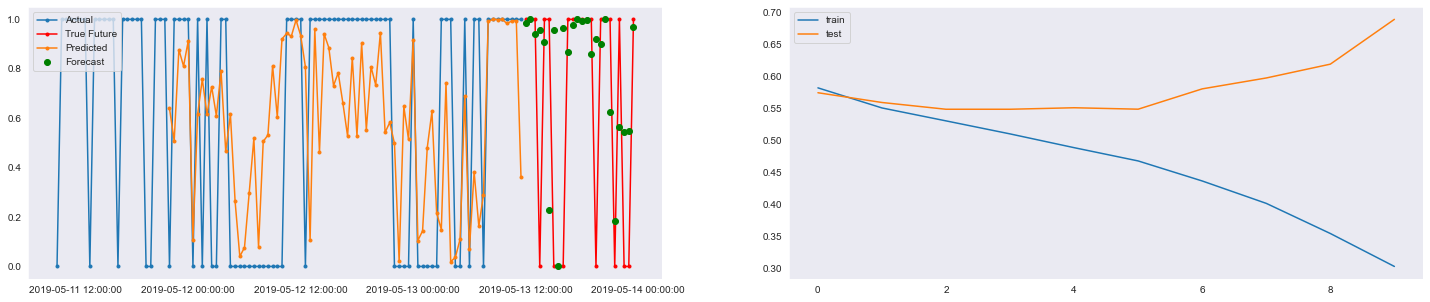

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,5))
axes[0].plot(x_axis_actual_plus_lags, inv_y_Dd[-number_to_plot_actual_plus_lags:-n_lags_Dd], ".-", label="Actual")
axes[0].plot(x_axis_actual, inv_y_Dd[-n_lags_Dd:], "r.-", label="True Future")

axes[0].plot(x_axis_plot_predicted, inv_yhat_Dd[-number_to_plot_actual:-n_lags_Dd], ".-", label="Predicted")
axes[0].plot(x_axis_plot_forecast, inv_yhat_Dd[-n_lags_Dd:], "go", label="Forecast")

axes[1].plot(history_Dd.history['loss'], label='train')
axes[1].plot(history_Dd.history['val_loss'], label='test')

axes[0].legend(loc="upper left")
axes[1].legend(loc="upper left")

xfmt = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
axes[0].xaxis.set_major_formatter(xfmt)

# LSTM met minder features

In [720]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import prince # for multiple correspondence analysis
from sklearn.feature_selection import SelectKBest, chi2 # for chi-squared feature selection
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

In [743]:
X = df_mod.drop(columns = ["dtg_melding"])
y = df_mod["dtg_melding"]

In [744]:
# categorical feature selection
sf = SelectKBest(chi2, k='all')
sf_fit = sf.fit(X, y)
# print feature scores
features = []
scores = []
for i in range(len(sf_fit.scores_)):
    features.append(X.columns[i])
    scores.append(sf_fit.scores_[i])
#     print(' %s: %f' % (X.columns[i], sf_fit.scores_[i]))

chi = pd.DataFrame()
chi["Features"] = features
chi["Scores"] = scores

In [759]:
slechtscorende = set()
kolommen = df_less_features.columns
# print(kolommen)
for b in chi[chi["Scores"] < 10]["Features"]:
    a = ''.join([i for i in b if not i.isdigit()])
    if a[-1] == "_":
        a = a[:-1]
    
    c = a.find("_") + 1

    if a[c:] not in kolommen:
        if a not in kolommen:
            a = a.replace(a[c-1:], "")
        
    slechtscorende.add(a)

slechtscorende

{'dag',
 'dagdeel',
 'dagvanjaar',
 'feestdag',
 'kwartaal',
 'maand',
 'minuten',
 'seizoen',
 'uitbereidend_gemiddelde',
 'uur',
 'weekdag',
 'weekvanjaar'}

In [937]:
new_lstm_less_features = df_less_features.drop(columns=slechtscorende)

In [938]:
categorical_features = ['maand', 'kwartaal', 'weekvanjaar', 'weekdag', 'dagvanjaar', 'dag', 'dagdeel', 'werktijd', 'werkdag','weekend', 'seizoen', 'feestdag', "uur", 'minuten']
categorical_features = list(set(categorical_features) - slechtscorende)
display(categorical_features)

for i in categorical_features:
    aa = pd.get_dummies(new_lstm_less_features[i],prefix=i,drop_first=False)
    new_lstm_less_features = pd.concat([new_lstm_less_features, aa], axis=1)
    new_lstm_less_features = new_lstm_less_features.drop(columns=[i])

['werkdag', 'weekend', 'werktijd']

# TEST MET MEERDERE PARAMETERS (DUURT 12 UUR!!!!!!, niet zomaar runnen)

In [776]:
# n_lagssss = [12, 24, 46]
# n_dropouts = [0.1, 0.2]
# n_epochs = [10, 15, 20]
# n_batch_sizes = [24, 64, 256, 512]

# counter = 0

# dict1 = dict()

# for epoch in n_epochs:
#     for lag in n_lagssss:
#         for dropout in n_dropouts:
#             for batchsize in n_batch_sizes:
#                 start_time = datetime.now()
                
#                 dict2 = dict()
#                 dict2["epoch"] = epoch
#                 dict2["lag"] = lag
#                 dict2["dropout"] = dropout
#                 dict2["batchsize"] = batchsize

#                 lstm_dataset = new_lstm_less_features.copy()
#                 values_Dd = lstm_dataset.values

#                 # ensure all data is float
#                 values_Dd = values_Dd.astype('float32')

#                 # normalize features
#                 scaler_Dd = MinMaxScaler()
#                 scaled_Dd = scaler_Dd.fit_transform(values_Dd)

#                 # specify the number of lag quart hours
#                 n_lags_Dd = lag
#                 n_features_Dd = len(lstm_dataset.columns)
#                 # print(n_features_Dd)

#                 # actual -124 tot -24
#                 # actual laatste -24
#                 # predicted -100 tot -24
#                 # predicted laatste -24

#                 number_to_plot_actual = 100
#                 number_to_plot_actual_plus_lags = number_to_plot_actual + n_lags_Dd
#                 x_axis_actual_plus_lags = sorted(df_mod.index[-number_to_plot_actual_plus_lags:-n_lags_Dd])
#                 x_axis_actual = sorted(df_mod.index[-n_lags_Dd:])

#                 x_axis_plot_predicted = sorted(df_mod.index[-number_to_plot_actual:-n_lags_Dd])
#                 x_axis_plot_forecast = sorted(df_mod.index[-n_lags_Dd:])

#                 # frame as supervised learning
#                 reframed_Dd = series_to_supervised(scaled_Dd, n_lags_Dd, 1)
#                 # display(reframed_Dd)

#                 # split into train and test sets
#                 values_Dd = reframed_Dd.values
#                 n_train_lags_Dd = round(len(values_Dd)*0.8)
#                 train_Dd = values_Dd[:n_train_lags_Dd, :]
#                 test_Dd = values_Dd[n_train_lags_Dd:, :]

#                 # split into input and outputs
#                 n_obs_Dd = n_lags_Dd * n_features_Dd
#                 train_X_Dd, train_y_Dd = train_Dd[:, :n_obs_Dd], train_Dd[:, -n_features_Dd]
#                 test_X_Dd, test_y_Dd = test_Dd[:, :n_obs_Dd], test_Dd[:, -n_features_Dd]
#                 # print(train_X_Dd.shape, len(train_X_Dd), train_y_Dd.shape)

#                 # reshape input to be 3D [samples, timesteps, features]
#                 train_X_Dd = train_X_Dd.reshape((train_X_Dd.shape[0], n_lags_Dd, n_features_Dd))
#                 test_X_Dd = test_X_Dd.reshape((test_X_Dd.shape[0], n_lags_Dd, n_features_Dd))
# #                 print(train_X_Dd.shape, train_y_Dd.shape, test_X_Dd.shape, test_y_Dd.shape)

#                 model_Dd = Sequential()
#                 model_Dd.add(LSTM(32, input_shape=(train_X_Dd.shape[1], train_X_Dd.shape[2])))
#                 model_Dd.add(Dense(16, activation="relu", kernel_initializer='he_uniform'))
#                 model_Dd.add(Dropout(dropout))
#                 model_Dd.add(Dense(1, activation="sigmoid", kernel_initializer='he_uniform'))
#                 model_Dd.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

#                 # fit network
#                 history_Dd = model_Dd.fit(train_X_Dd, train_y_Dd, epochs=epoch, batch_size=batchsize, validation_data=(test_X_Dd, test_y_Dd), verbose=2)

#                 test_loss, test_acc = model_Dd.evaluate(test_X_Dd, test_y_Dd)
# #                 print('Test loss: %.3f' % test_loss)
# #                 print('Test acc: %.3f' % test_acc)

#                 # make a prediction
#                 yhat_Dd = model_Dd.predict(test_X_Dd)
#                 test_X_Dd = test_X_Dd.reshape((test_X_Dd.shape[0], n_lags_Dd*n_features_Dd))

#                 # invert scaling for forecast
#                 tester_Dd = n_features_Dd - 1
#                 inv_yhat_Dd = concatenate((yhat_Dd, test_X_Dd[:, -tester_Dd:]), axis=1)
#                 inv_yhat_Dd = scaler_Dd.inverse_transform(inv_yhat_Dd)
#                 inv_yhat_Dd = inv_yhat_Dd[:,0]

#                 # invert scaling for actual
#                 test_y_Dd = test_y_Dd.reshape((len(test_y_Dd), 1))
#                 inv_y_Dd = concatenate((test_y_Dd, test_X_Dd[:, -tester_Dd:]), axis=1)
#                 inv_y_Dd = scaler_Dd.inverse_transform(inv_y_Dd)
#                 inv_y_Dd = inv_y_Dd[:,0]

#                 dict2["x_axis_actual_plus_lags"] = x_axis_actual_plus_lags
#                 dict2["x_axis_actual"] = x_axis_actual
#                 dict2["y_axis_actual_plus_lags"] = inv_y_Dd[-number_to_plot_actual_plus_lags:-n_lags_Dd]
#                 dict2["y_axis_actual"] = inv_y_Dd[-n_lags_Dd:]
                
#                 dict2["x_axis_plot_predicted"] = x_axis_plot_predicted
#                 dict2["x_axis_plot_forecast"] = x_axis_plot_forecast
#                 dict2["y_axis_plot_predicted"] = inv_yhat_Dd[-number_to_plot_actual:-n_lags_Dd]
#                 dict2["y_axis_plot_forecast"] = inv_yhat_Dd[-n_lags_Dd:]
                
#                 dict2["history_loss"] = history_Dd.history['loss']
#                 dict2["history_val_loss"] = history_Dd.history['val_loss']
                
#                 dict2["history_accuracy"] = history_Dd.history['accuracy']
#                 dict2["history_val_accuracy"] = history_Dd.history['val_accuracy']
                
#                 dict2["test_acc_evaluation"] = test_acc
                
#                 end_time = datetime.now()
#                 duration = end_time - start_time
                
#                 dict2["duration"] = duration

#                 dict1[counter] = dict2
#                 counter += 1
                
                
                
# #                 print('Duration: {}'.format(end_time - start_time))

Epoch 1/10
1149/1149 - 49s - loss: 0.5693 - accuracy: 0.7165 - val_loss: 0.5551 - val_accuracy: 0.7261
Epoch 2/10
1149/1149 - 45s - loss: 0.5374 - accuracy: 0.7378 - val_loss: 0.5433 - val_accuracy: 0.7316
Epoch 3/10
1149/1149 - 45s - loss: 0.5234 - accuracy: 0.7468 - val_loss: 0.5387 - val_accuracy: 0.7340
Epoch 4/10
1149/1149 - 45s - loss: 0.5154 - accuracy: 0.7496 - val_loss: 0.5409 - val_accuracy: 0.7356
Epoch 5/10
1149/1149 - 45s - loss: 0.5113 - accuracy: 0.7507 - val_loss: 0.5292 - val_accuracy: 0.7388
Epoch 6/10
1149/1149 - 45s - loss: 0.5092 - accuracy: 0.7530 - val_loss: 0.5341 - val_accuracy: 0.7328
Epoch 7/10
1149/1149 - 45s - loss: 0.5062 - accuracy: 0.7538 - val_loss: 0.5293 - val_accuracy: 0.7377
Epoch 8/10
1149/1149 - 45s - loss: 0.5030 - accuracy: 0.7561 - val_loss: 0.5241 - val_accuracy: 0.7409
Epoch 9/10
1149/1149 - 45s - loss: 0.5020 - accuracy: 0.7564 - val_loss: 0.5228 - val_accuracy: 0.7417
Epoch 10/10
1149/1149 - 44s - loss: 0.4980 - accuracy: 0.7602 - val_loss:

Epoch 6/10
54/54 - 22s - loss: 0.5387 - accuracy: 0.7368 - val_loss: 0.5574 - val_accuracy: 0.7192
Epoch 7/10
54/54 - 22s - loss: 0.5342 - accuracy: 0.7368 - val_loss: 0.5486 - val_accuracy: 0.7331
Epoch 8/10
54/54 - 22s - loss: 0.5321 - accuracy: 0.7391 - val_loss: 0.5463 - val_accuracy: 0.7316
Epoch 9/10
54/54 - 22s - loss: 0.5245 - accuracy: 0.7414 - val_loss: 0.5369 - val_accuracy: 0.7408
Epoch 10/10
54/54 - 22s - loss: 0.5200 - accuracy: 0.7477 - val_loss: 0.5396 - val_accuracy: 0.7354
216/216 [==============================] - 4s 18ms/step - loss: 0.5396 - accuracy: 0.7354
Epoch 1/10
1148/1148 - 55s - loss: 0.5669 - accuracy: 0.7175 - val_loss: 0.5654 - val_accuracy: 0.7166
Epoch 2/10
1148/1148 - 54s - loss: 0.5376 - accuracy: 0.7376 - val_loss: 0.5462 - val_accuracy: 0.7265
Epoch 3/10
1148/1148 - 51s - loss: 0.5244 - accuracy: 0.7447 - val_loss: 0.5431 - val_accuracy: 0.7297
Epoch 4/10
1148/1148 - 51s - loss: 0.5173 - accuracy: 0.7481 - val_loss: 0.5295 - val_accuracy: 0.7375
Ep

216/216 [==============================] - 4s 19ms/step - loss: 0.5243 - accuracy: 0.7407
Epoch 1/10
54/54 - 25s - loss: 0.5968 - accuracy: 0.6907 - val_loss: 0.5808 - val_accuracy: 0.6996
Epoch 2/10
54/54 - 23s - loss: 0.5686 - accuracy: 0.7153 - val_loss: 0.5732 - val_accuracy: 0.7107
Epoch 3/10
54/54 - 23s - loss: 0.5611 - accuracy: 0.7248 - val_loss: 0.5725 - val_accuracy: 0.7139
Epoch 4/10
54/54 - 23s - loss: 0.5517 - accuracy: 0.7279 - val_loss: 0.5643 - val_accuracy: 0.7188
Epoch 5/10
54/54 - 23s - loss: 0.5472 - accuracy: 0.7304 - val_loss: 0.5694 - val_accuracy: 0.7166
Epoch 6/10
54/54 - 23s - loss: 0.5427 - accuracy: 0.7322 - val_loss: 0.5531 - val_accuracy: 0.7247
Epoch 7/10
54/54 - 23s - loss: 0.5365 - accuracy: 0.7368 - val_loss: 0.5535 - val_accuracy: 0.7246
Epoch 8/10
54/54 - 23s - loss: 0.5330 - accuracy: 0.7391 - val_loss: 0.5516 - val_accuracy: 0.7294
Epoch 9/10
54/54 - 23s - loss: 0.5303 - accuracy: 0.7402 - val_loss: 0.5487 - val_accuracy: 0.7224
Epoch 10/10
54/54 -

Epoch 5/10
108/108 - 25s - loss: 0.5404 - accuracy: 0.7357 - val_loss: 0.5492 - val_accuracy: 0.7333
Epoch 6/10
108/108 - 25s - loss: 0.5367 - accuracy: 0.7371 - val_loss: 0.5522 - val_accuracy: 0.7266
Epoch 7/10
108/108 - 25s - loss: 0.5310 - accuracy: 0.7382 - val_loss: 0.5410 - val_accuracy: 0.7357
Epoch 8/10
108/108 - 25s - loss: 0.5249 - accuracy: 0.7424 - val_loss: 0.5357 - val_accuracy: 0.7388
Epoch 9/10
108/108 - 25s - loss: 0.5177 - accuracy: 0.7466 - val_loss: 0.5326 - val_accuracy: 0.7360
Epoch 10/10
108/108 - 25s - loss: 0.5146 - accuracy: 0.7503 - val_loss: 0.5386 - val_accuracy: 0.7367
216/216 [==============================] - 4s 19ms/step - loss: 0.5386 - accuracy: 0.7367
Epoch 1/10
54/54 - 24s - loss: 0.6032 - accuracy: 0.6809 - val_loss: 0.5908 - val_accuracy: 0.6920
Epoch 2/10
54/54 - 23s - loss: 0.5726 - accuracy: 0.7147 - val_loss: 0.5772 - val_accuracy: 0.7051
Epoch 3/10
54/54 - 23s - loss: 0.5603 - accuracy: 0.7232 - val_loss: 0.5690 - val_accuracy: 0.7152
Epoch 

Epoch 2/15
431/431 - 34s - loss: 0.5439 - accuracy: 0.7310 - val_loss: 0.5396 - val_accuracy: 0.7289
Epoch 3/15
431/431 - 35s - loss: 0.5250 - accuracy: 0.7435 - val_loss: 0.5372 - val_accuracy: 0.7349
Epoch 4/15
431/431 - 34s - loss: 0.5187 - accuracy: 0.7456 - val_loss: 0.5343 - val_accuracy: 0.7304
Epoch 5/15
431/431 - 35s - loss: 0.5158 - accuracy: 0.7500 - val_loss: 0.5345 - val_accuracy: 0.7366
Epoch 6/15
431/431 - 34s - loss: 0.5133 - accuracy: 0.7506 - val_loss: 0.5354 - val_accuracy: 0.7362
Epoch 7/15
431/431 - 35s - loss: 0.5102 - accuracy: 0.7518 - val_loss: 0.5341 - val_accuracy: 0.7369
Epoch 8/15
431/431 - 35s - loss: 0.5076 - accuracy: 0.7531 - val_loss: 0.5269 - val_accuracy: 0.7390
Epoch 9/15
431/431 - 35s - loss: 0.5049 - accuracy: 0.7541 - val_loss: 0.5274 - val_accuracy: 0.7426
Epoch 10/15
431/431 - 35s - loss: 0.5030 - accuracy: 0.7576 - val_loss: 0.5219 - val_accuracy: 0.7427
Epoch 11/15
431/431 - 35s - loss: 0.4991 - accuracy: 0.7593 - val_loss: 0.5216 - val_accur

Epoch 4/15
108/108 - 25s - loss: 0.5444 - accuracy: 0.7334 - val_loss: 0.5544 - val_accuracy: 0.7276
Epoch 5/15
108/108 - 25s - loss: 0.5380 - accuracy: 0.7361 - val_loss: 0.5440 - val_accuracy: 0.7317
Epoch 6/15
108/108 - 24s - loss: 0.5301 - accuracy: 0.7405 - val_loss: 0.5438 - val_accuracy: 0.7292
Epoch 7/15
108/108 - 25s - loss: 0.5222 - accuracy: 0.7443 - val_loss: 0.5368 - val_accuracy: 0.7314
Epoch 8/15
108/108 - 25s - loss: 0.5185 - accuracy: 0.7464 - val_loss: 0.5323 - val_accuracy: 0.7349
Epoch 9/15
108/108 - 25s - loss: 0.5180 - accuracy: 0.7467 - val_loss: 0.5299 - val_accuracy: 0.7352
Epoch 10/15
108/108 - 25s - loss: 0.5130 - accuracy: 0.7504 - val_loss: 0.5361 - val_accuracy: 0.7409
Epoch 11/15
108/108 - 25s - loss: 0.5094 - accuracy: 0.7554 - val_loss: 0.5288 - val_accuracy: 0.7433
Epoch 12/15
108/108 - 26s - loss: 0.5055 - accuracy: 0.7567 - val_loss: 0.5293 - val_accuracy: 0.7401
Epoch 13/15
108/108 - 25s - loss: 0.5048 - accuracy: 0.7565 - val_loss: 0.5204 - val_acc

Epoch 6/15
54/54 - 22s - loss: 0.5454 - accuracy: 0.7340 - val_loss: 0.5594 - val_accuracy: 0.7219
Epoch 7/15
54/54 - 23s - loss: 0.5421 - accuracy: 0.7332 - val_loss: 0.5586 - val_accuracy: 0.7195
Epoch 8/15
54/54 - 23s - loss: 0.5384 - accuracy: 0.7344 - val_loss: 0.5522 - val_accuracy: 0.7264
Epoch 9/15
54/54 - 22s - loss: 0.5328 - accuracy: 0.7377 - val_loss: 0.5472 - val_accuracy: 0.7289
Epoch 10/15
54/54 - 22s - loss: 0.5291 - accuracy: 0.7394 - val_loss: 0.5453 - val_accuracy: 0.7319
Epoch 11/15
54/54 - 22s - loss: 0.5264 - accuracy: 0.7411 - val_loss: 0.5416 - val_accuracy: 0.7337
Epoch 12/15
54/54 - 23s - loss: 0.5243 - accuracy: 0.7439 - val_loss: 0.5378 - val_accuracy: 0.7356
Epoch 13/15
54/54 - 23s - loss: 0.5199 - accuracy: 0.7448 - val_loss: 0.5473 - val_accuracy: 0.7324
Epoch 14/15
54/54 - 23s - loss: 0.5164 - accuracy: 0.7461 - val_loss: 0.5339 - val_accuracy: 0.7385
Epoch 15/15
54/54 - 22s - loss: 0.5143 - accuracy: 0.7486 - val_loss: 0.5332 - val_accuracy: 0.7375
216/

Epoch 8/20
1149/1149 - 45s - loss: 0.5017 - accuracy: 0.7558 - val_loss: 0.5265 - val_accuracy: 0.7415
Epoch 9/20
1149/1149 - 45s - loss: 0.5000 - accuracy: 0.7561 - val_loss: 0.5229 - val_accuracy: 0.7431
Epoch 10/20
1149/1149 - 45s - loss: 0.4979 - accuracy: 0.7586 - val_loss: 0.5290 - val_accuracy: 0.7345
Epoch 11/20
1149/1149 - 45s - loss: 0.4957 - accuracy: 0.7595 - val_loss: 0.5279 - val_accuracy: 0.7392
Epoch 12/20
1149/1149 - 45s - loss: 0.4941 - accuracy: 0.7600 - val_loss: 0.5190 - val_accuracy: 0.7406
Epoch 13/20
1149/1149 - 45s - loss: 0.4923 - accuracy: 0.7634 - val_loss: 0.5194 - val_accuracy: 0.7425
Epoch 14/20
1149/1149 - 45s - loss: 0.4898 - accuracy: 0.7632 - val_loss: 0.5202 - val_accuracy: 0.7440
Epoch 15/20
1149/1149 - 45s - loss: 0.4874 - accuracy: 0.7654 - val_loss: 0.5270 - val_accuracy: 0.7437
Epoch 16/20
1149/1149 - 45s - loss: 0.4859 - accuracy: 0.7666 - val_loss: 0.5232 - val_accuracy: 0.7431
Epoch 17/20
1149/1149 - 45s - loss: 0.4836 - accuracy: 0.7672 - va

Epoch 6/20
1149/1149 - 45s - loss: 0.5129 - accuracy: 0.7510 - val_loss: 0.5435 - val_accuracy: 0.7274
Epoch 7/20
1149/1149 - 45s - loss: 0.5101 - accuracy: 0.7513 - val_loss: 0.5331 - val_accuracy: 0.7338
Epoch 8/20
1149/1149 - 45s - loss: 0.5075 - accuracy: 0.7555 - val_loss: 0.5333 - val_accuracy: 0.7331
Epoch 9/20
1149/1149 - 45s - loss: 0.5047 - accuracy: 0.7569 - val_loss: 0.5335 - val_accuracy: 0.7364
Epoch 10/20
1149/1149 - 45s - loss: 0.5032 - accuracy: 0.7583 - val_loss: 0.5288 - val_accuracy: 0.7412
Epoch 11/20
1149/1149 - 45s - loss: 0.5013 - accuracy: 0.7580 - val_loss: 0.5300 - val_accuracy: 0.7347
Epoch 12/20
1149/1149 - 45s - loss: 0.4999 - accuracy: 0.7581 - val_loss: 0.5223 - val_accuracy: 0.7402
Epoch 13/20
1149/1149 - 45s - loss: 0.4980 - accuracy: 0.7590 - val_loss: 0.5221 - val_accuracy: 0.7350
Epoch 14/20
1149/1149 - 45s - loss: 0.4971 - accuracy: 0.7610 - val_loss: 0.5195 - val_accuracy: 0.7424
Epoch 15/20
1149/1149 - 45s - loss: 0.4956 - accuracy: 0.7614 - val_

Epoch 4/20
1148/1148 - 1862s - loss: 0.5171 - accuracy: 0.7476 - val_loss: 0.5369 - val_accuracy: 0.7336
Epoch 5/20
1148/1148 - 1347s - loss: 0.5127 - accuracy: 0.7510 - val_loss: 0.5298 - val_accuracy: 0.7378
Epoch 6/20
1148/1148 - 85s - loss: 0.5098 - accuracy: 0.7544 - val_loss: 0.5271 - val_accuracy: 0.7365
Epoch 7/20
1148/1148 - 78s - loss: 0.5072 - accuracy: 0.7528 - val_loss: 0.5292 - val_accuracy: 0.7358
Epoch 8/20
1148/1148 - 79s - loss: 0.5028 - accuracy: 0.7549 - val_loss: 0.5267 - val_accuracy: 0.7398
Epoch 9/20
1148/1148 - 79s - loss: 0.5024 - accuracy: 0.7576 - val_loss: 0.5290 - val_accuracy: 0.7384
Epoch 10/20
1148/1148 - 79s - loss: 0.4988 - accuracy: 0.7592 - val_loss: 0.5225 - val_accuracy: 0.7384
Epoch 11/20
1148/1148 - 79s - loss: 0.4958 - accuracy: 0.7608 - val_loss: 0.5208 - val_accuracy: 0.7375
Epoch 12/20
1148/1148 - 79s - loss: 0.4941 - accuracy: 0.7624 - val_loss: 0.5167 - val_accuracy: 0.7454
Epoch 13/20
1148/1148 - 80s - loss: 0.4912 - accuracy: 0.7654 - va

Epoch 2/20
1148/1148 - 51s - loss: 0.5420 - accuracy: 0.7375 - val_loss: 0.5400 - val_accuracy: 0.7353
Epoch 3/20
1148/1148 - 51s - loss: 0.5276 - accuracy: 0.7438 - val_loss: 0.5314 - val_accuracy: 0.7382
Epoch 4/20
1148/1148 - 51s - loss: 0.5209 - accuracy: 0.7472 - val_loss: 0.5290 - val_accuracy: 0.7416
Epoch 5/20
1148/1148 - 51s - loss: 0.5182 - accuracy: 0.7490 - val_loss: 0.5331 - val_accuracy: 0.7372
Epoch 6/20
1148/1148 - 51s - loss: 0.5138 - accuracy: 0.7524 - val_loss: 0.5300 - val_accuracy: 0.7377
Epoch 7/20
1148/1148 - 51s - loss: 0.5112 - accuracy: 0.7522 - val_loss: 0.5280 - val_accuracy: 0.7382
Epoch 8/20
1148/1148 - 51s - loss: 0.5096 - accuracy: 0.7532 - val_loss: 0.5254 - val_accuracy: 0.7401
Epoch 9/20
1148/1148 - 51s - loss: 0.5073 - accuracy: 0.7546 - val_loss: 0.5294 - val_accuracy: 0.7346
Epoch 10/20
1148/1148 - 51s - loss: 0.5045 - accuracy: 0.7561 - val_loss: 0.5191 - val_accuracy: 0.7446
Epoch 11/20
1148/1148 - 51s - loss: 0.5016 - accuracy: 0.7574 - val_loss

Epoch 20/20
54/54 - 23s - loss: 0.5009 - accuracy: 0.7589 - val_loss: 0.5181 - val_accuracy: 0.7455
216/216 [==============================] - 4s 19ms/step - loss: 0.5181 - accuracy: 0.7455
Epoch 1/20
1148/1148 - 46s - loss: 0.5699 - accuracy: 0.7128 - val_loss: 0.5713 - val_accuracy: 0.7149
Epoch 2/20
1148/1148 - 45s - loss: 0.5385 - accuracy: 0.7359 - val_loss: 0.5444 - val_accuracy: 0.7276
Epoch 3/20
1148/1148 - 44s - loss: 0.5235 - accuracy: 0.7434 - val_loss: 0.5373 - val_accuracy: 0.7351
Epoch 4/20
1148/1148 - 44s - loss: 0.5159 - accuracy: 0.7474 - val_loss: 0.5264 - val_accuracy: 0.7405
Epoch 5/20
1148/1148 - 44s - loss: 0.5131 - accuracy: 0.7502 - val_loss: 0.5348 - val_accuracy: 0.7407
Epoch 6/20
1148/1148 - 44s - loss: 0.5108 - accuracy: 0.7510 - val_loss: 0.5225 - val_accuracy: 0.7456
Epoch 7/20
1148/1148 - 44s - loss: 0.5057 - accuracy: 0.7546 - val_loss: 0.5272 - val_accuracy: 0.7378
Epoch 8/20
1148/1148 - 44s - loss: 0.5034 - accuracy: 0.7551 - val_loss: 0.5243 - val_acc

54/54 - 23s - loss: 0.5100 - accuracy: 0.7524 - val_loss: 0.5271 - val_accuracy: 0.7402
Epoch 18/20
54/54 - 23s - loss: 0.5063 - accuracy: 0.7548 - val_loss: 0.5236 - val_accuracy: 0.7427
Epoch 19/20
54/54 - 23s - loss: 0.5051 - accuracy: 0.7558 - val_loss: 0.5249 - val_accuracy: 0.7383
Epoch 20/20
54/54 - 23s - loss: 0.5040 - accuracy: 0.7558 - val_loss: 0.5268 - val_accuracy: 0.7411
216/216 [==============================] - 4s 19ms/step - loss: 0.5268 - accuracy: 0.7411
Epoch 1/20
1148/1148 - 46s - loss: 0.5734 - accuracy: 0.7157 - val_loss: 0.5669 - val_accuracy: 0.7103
Epoch 2/20
1148/1148 - 44s - loss: 0.5409 - accuracy: 0.7365 - val_loss: 0.5580 - val_accuracy: 0.7247
Epoch 3/20
1148/1148 - 44s - loss: 0.5257 - accuracy: 0.7449 - val_loss: 0.5479 - val_accuracy: 0.7295
Epoch 4/20
1148/1148 - 45s - loss: 0.5192 - accuracy: 0.7482 - val_loss: 0.5310 - val_accuracy: 0.7370
Epoch 5/20
1148/1148 - 44s - loss: 0.5152 - accuracy: 0.7507 - val_loss: 0.5299 - val_accuracy: 0.7360
Epoch 6

Epoch 15/20
54/54 - 23s - loss: 0.5167 - accuracy: 0.7487 - val_loss: 0.5369 - val_accuracy: 0.7327
Epoch 16/20
54/54 - 23s - loss: 0.5131 - accuracy: 0.7515 - val_loss: 0.5317 - val_accuracy: 0.7344
Epoch 17/20
54/54 - 23s - loss: 0.5117 - accuracy: 0.7521 - val_loss: 0.5279 - val_accuracy: 0.7427
Epoch 18/20
54/54 - 23s - loss: 0.5078 - accuracy: 0.7540 - val_loss: 0.5235 - val_accuracy: 0.7462
Epoch 19/20
54/54 - 23s - loss: 0.5082 - accuracy: 0.7526 - val_loss: 0.5304 - val_accuracy: 0.7424
Epoch 20/20
54/54 - 23s - loss: 0.5060 - accuracy: 0.7559 - val_loss: 0.5275 - val_accuracy: 0.7421
216/216 [==============================] - 4s 20ms/step - loss: 0.5275 - accuracy: 0.7421


In [949]:
# heights = [1 for i in range(len(dict1))]

In [1]:
# # dict1
# fig, axes = plt.subplots(nrows=len(dict1)*2, ncols=3, figsize=(50, 500))
# nrows=len(dict1)
# ncols=3
        
# for i in range(nrows):
# #     print(dict1[i]["lookback"])
#     dict3 = dict()
#     dict4 = dict()
#     dict4["test_acc_evaluation"] = dict1[i]["test_acc_evaluation"]
#     dict3["lag"] = dict1[i]["lag"]
#     dict3["epoch"] = dict1[i]["epoch"]
#     dict3["dropout"] = dict1[i]["dropout"]
#     dict3["batchsize"] = dict1[i]["batchsize"]
#     dict3["duration"] = dict1[i]["duration"]
    
# #         print(dict1[i]["inv_y"][-100:])
#     axes[i][0].plot(dict1[i]["x_axis_actual_plus_lags"], dict1[i]["y_axis_actual_plus_lags"], ".-", label="Actual")
#     axes[i][0].plot(dict1[i]["x_axis_actual"], dict1[i]["y_axis_actual"], "r.-", label="True Future")
    
#     axes[i][0].plot(dict1[i]["x_axis_plot_predicted"], dict1[i]["y_axis_plot_predicted"], ".-", label="Predicted")
#     axes[i][0].plot(dict1[i]["x_axis_plot_forecast"], dict1[i]["y_axis_plot_forecast"], "go", label="Forecast")
#     axes[i][0].title.set_text(dict4)
    
#     axes[i][1].plot(dict1[i]["history_loss"], label='train loss')
#     axes[i][1].plot(dict1[i]["history_val_loss"], label='test loss')
#     axes[i][1].title.set_text(dict3)
    
#     axes[i][2].plot(dict1[i]["history_accuracy"], label='train accuracy')
#     axes[i][2].plot(dict1[i]["history_val_accuracy"], label='test accuracy')
#     axes[i][2].title.set_text(dict3)
    
#     axes[i][0].legend(loc="upper left")
#     axes[i][1].legend(loc="upper left")
#     axes[i][2].legend(loc="upper left")
#     xfmt = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
#     axes[i][0].xaxis.set_major_formatter(xfmt)

# # print(history_Dd.history["loss"])

NameError: name 'plt' is not defined

In [792]:
# dict1[0]["duration"]
# total_duration = np.sum([dict1[i]["duration"] for i in dict1])

In [794]:
# print('Duration: {}'.format(total_duration))

Duration: 12:11:56.569318


In [925]:
# names = list(dict1[0].keys())[:4]
# names = names + ['history_loss_first', 'history_loss_last', 'history_val_loss_first', 'history_val_loss_last']
# names = names + list(dict1[0].keys())[-2:]
# names

['epoch',
 'lag',
 'dropout',
 'batchsize',
 'history_loss_first',
 'history_loss_last',
 'history_val_loss_first',
 'history_val_loss_last',
 'test_acc_evaluation',
 'duration']

In [959]:
# data = []
# for i in dict1:
#     p = list(dict1[i].values())[:4]
#     p = p + [list(dict1[i].values())[12][0], list(dict1[i].values())[12][-1]]
#     p = p + [list(dict1[i].values())[13][0], list(dict1[i].values())[13][-1]]
#     p = p + list(dict1[i].values())[-2:]
#     data.append(p)
    
# # data

In [927]:
# evaluation = pd.DataFrame(columns=names, data=data)

In [960]:
# display(evaluation.sort_values(['test_acc_evaluation'], ascending=[False]))
# print("Total duration :", evaluation["duration"].sum())

,epoch,lag,dropout,batchsize,history_loss_first,history_loss_last,history_val_loss_first,history_val_loss_last,test_acc_evaluation,duration
57,20,24,0.1,64,0.575798,0.482704,0.567696,0.514481,0.750000,0 days 00:11:46.703988
70,20,46,0.2,256,0.592225,0.493878,0.578920,0.516336,0.748801,0 days 00:08:38.578883
58,20,24,0.1,256,0.589105,0.490059,0.583276,0.518129,0.748113,0 days 00:08:24.625588
33,15,24,0.1,64,0.573976,0.491433,0.559559,0.516949,0.747822,0 days 00:08:48.787185
51,20,12,0.1,512,0.603304,0.500488,0.585254,0.519591,0.747605,0 days 00:07:09.895361
...,...,...,...,...,...,...,...,...,...,...
30,15,12,0.2,256,0.590080,0.503330,0.579437,0.533799,0.733672,0 days 00:05:43.308183
3,10,12,0.1,512,0.610772,0.526950,0.592797,0.538990,0.732801,0 days 00:03:40.770446
2,10,12,0.1,256,0.587166,0.508847,0.573983,0.529590,0.732221,0 days 00:03:51.247083
23,10,46,0.2,512,0.603215,0.530601,0.590833,0.544635,0.731222,0 days 00:03:57.199395


Total duration : 0 days 12:11:56.569318


In [966]:
# top3 = evaluation.sort_values(['test_acc_evaluation'], ascending=[False])
# # print("Total duration :", evaluation["duration"].sum())
# top3 = top3.index[:3]
# top3

Int64Index([57, 70, 58], dtype='int64')

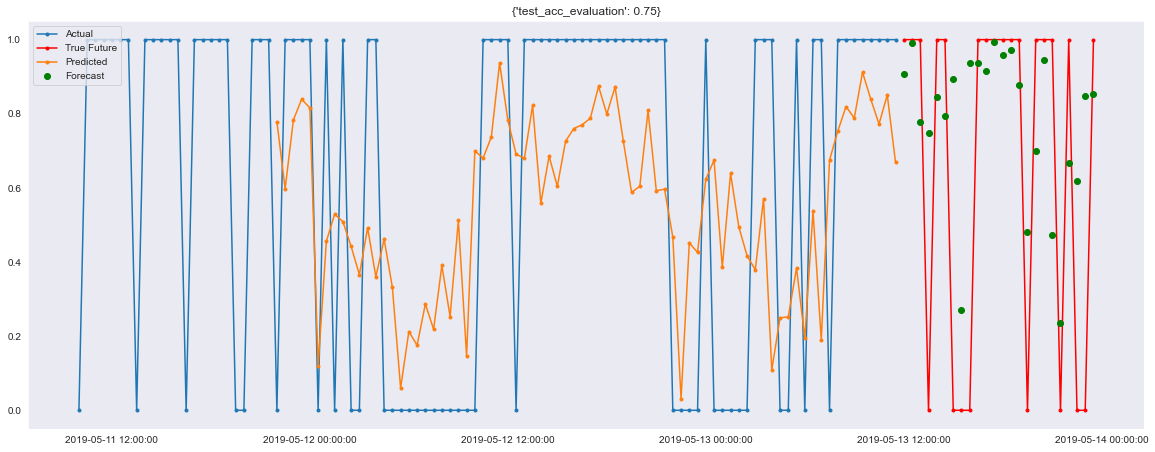

In [997]:
# plt.rcParams["figure.figsize"] = (20,7.5)

# ax = plt.gca()
# dict3 = dict()
# dict4 = dict()
# dict4["test_acc_evaluation"] = dict1[top3[0]]["test_acc_evaluation"]
# dict3["lag"] = dict1[top3[0]]["lag"]
# dict3["epoch"] = dict1[top3[0]]["epoch"]
# dict3["dropout"] = dict1[top3[0]]["dropout"]
# dict3["batchsize"] = dict1[top3[0]]["batchsize"]
# dict3["duration"] = dict1[top3[0]]["duration"]



# plt.savefig('Best_model.png')
# plt.show()


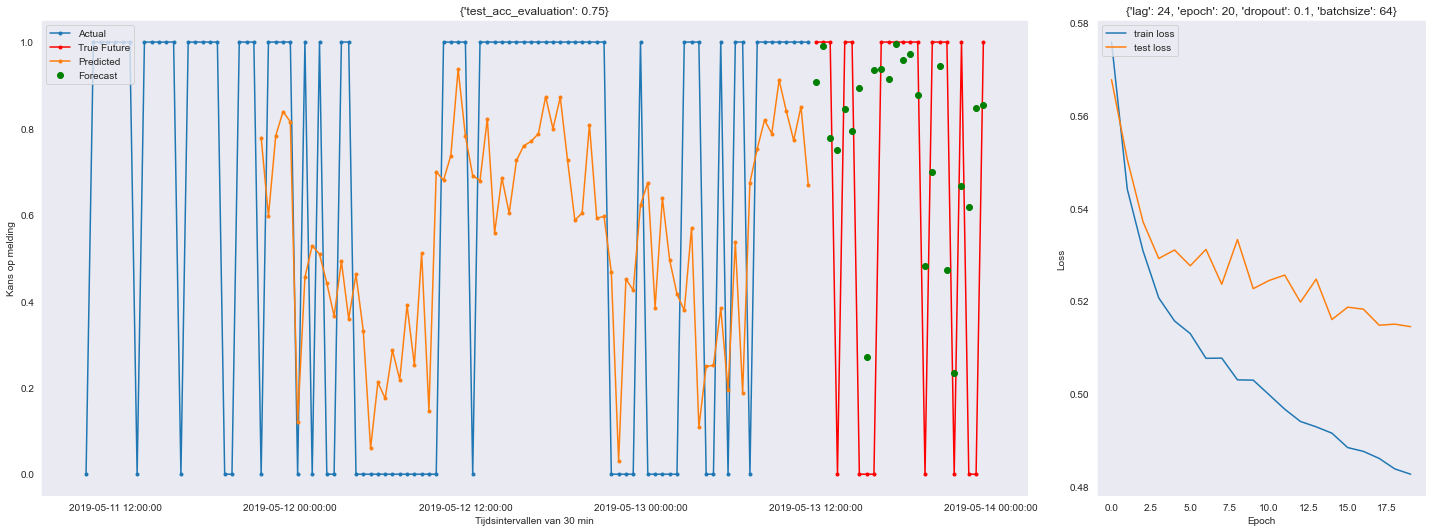

In [1034]:
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7.5), gridspec_kw={'width_ratios': [3, 1]})

# dict3 = dict()
# dict4 = dict()
# dict4["test_acc_evaluation"] = dict1[top3[0]]["test_acc_evaluation"]
# dict3["lag"] = dict1[top3[0]]["lag"]
# dict3["epoch"] = dict1[top3[0]]["epoch"]
# dict3["dropout"] = dict1[top3[0]]["dropout"]
# dict3["batchsize"] = dict1[top3[0]]["batchsize"]

# axes[0].plot(dict1[top3[0]]["x_axis_actual_plus_lags"], dict1[top3[0]]["y_axis_actual_plus_lags"], ".-", label="Actual")
# axes[0].plot(dict1[top3[0]]["x_axis_actual"], dict1[top3[0]]["y_axis_actual"], "r.-", label="True Future")

# axes[0].plot(dict1[top3[0]]["x_axis_plot_predicted"], dict1[top3[0]]["y_axis_plot_predicted"], ".-", label="Predicted")
# axes[0].plot(dict1[top3[0]]["x_axis_plot_forecast"], dict1[top3[0]]["y_axis_plot_forecast"], "go", label="Forecast")
# axes[0].title.set_text(dict4)

# axes[0].legend(loc="upper left")
# xfmt = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
# axes[0].xaxis.set_major_formatter(xfmt)

# axes[1].plot(dict1[top3[0]]["history_loss"], label='train loss')
# axes[1].plot(dict1[top3[0]]["history_val_loss"], label='test loss')
# axes[1].title.set_text(dict3)

# axes[0].legend(loc="upper left")
# axes[1].legend(loc="upper left")

# axes[0].set_xlabel('Tijdsintervallen van 30 min')
# axes[0].set_ylabel('Kans op melding')

# axes[1].set_xlabel('Epoch')
# axes[1].set_ylabel('Loss')

# fig.tight_layout()
# fig.savefig('Best_model.png')

